In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

In [4]:
def create_graph_data(df, node_list):
    node_map = {node: idx for idx, node in enumerate(node_list)}
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)
    return node_features, edge_index, labels

In [5]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
# Create the graph dataset
node_features, edge_index, labels = create_graph_data(df, node_list)

In [7]:
# Save the dataset to a file
torch.save((node_features, edge_index, labels), 'graph_dataset.pt')
print("Graph dataset saved as 'graph_dataset.pt'")

Graph dataset saved as 'graph_dataset.pt'


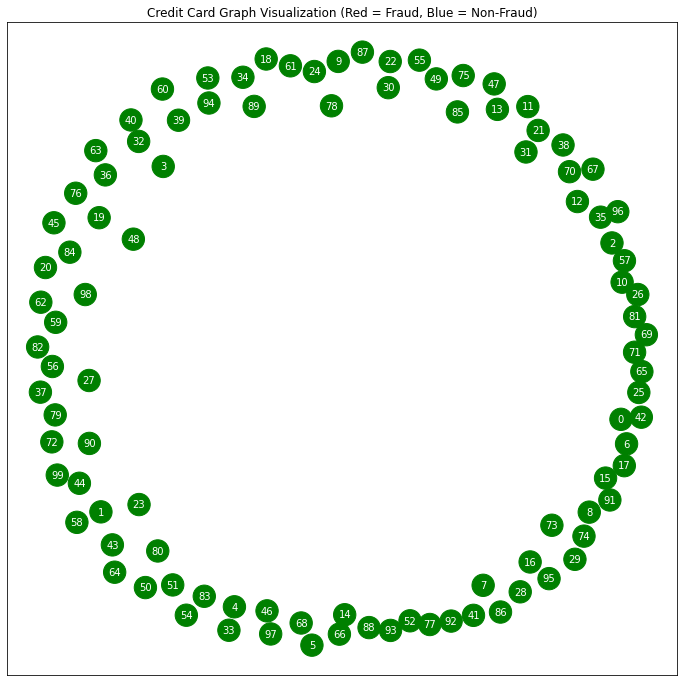

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to visualize the graph dataset
def visualize_graph(node_features, edge_index, labels, num_nodes_to_display=100):
    # Create a graph using networkx
    G = nx.Graph()

    # Add nodes with their labels (fraud or non-fraud) as node attributes
    for i in range(min(num_nodes_to_display, node_features.size(0))):
        label = labels[i].item()  # Get label (0: non-fraud, 1: fraud)
        G.add_node(i, label=label)

    # Add edges based on edge_index
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i]
        if u < num_nodes_to_display and v < num_nodes_to_display:
            G.add_edge(u.item(), v.item())

    # Set node color: red for fraud (1), blue for non-fraud (0)
    color_map = ['red' if G.nodes[node]['label'] == 1 else 'green' for node in G]

    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx(
        G, 
        node_color=color_map, 
        with_labels=True, 
        node_size=500, 
        font_size=10, 
        font_color='white'
    )
    plt.title('Credit Card Graph Visualization (Red = Fraud, Blue = Non-Fraud)')
    plt.show()

# Load the previously saved dataset
node_features, edge_index, labels = torch.load('graph_dataset.pt')  # Use the file path where you saved the dataset

# Visualize the first 100 nodes and edges of the graph
visualize_graph(node_features, edge_index, labels, num_nodes_to_display=100)